In [0]:
# code for google colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import os
os.chdir('/content/gdrive/My Drive/CMPT-733/')

Mounted at /content/gdrive


In [0]:
from math import sqrt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
from pandas import Series
import numpy as np

In [0]:
def abc(yhat,test_X):
  l = []
  for i in zip(yhat,test_X):
    l.append([i[1][0][0],i[1][0][1],i[1][0][2],i[1][0][3],i[1][0][4],i[0][0]])
  return pd.DataFrame(l)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
df = pd.read_csv('Neighbourhood_model_data.csv')

In [0]:
df = df[df['NEIGHBOURHOOD_NAME'] == 'West End']

In [0]:
postals = df['NEIGHBOURHOOD_NAME'].unique()

In [0]:
df = df[df['NEIGHBOURHOOD_NAME'] == 'West End']
df = df[['INTEREST_RATE','CURRENT_MEDIAN_PRICE']]

In [0]:
values = df.astype('float32')
scaled_down = (values-values.min())/(values.max()-values.min())
data = series_to_supervised(scaled_down,2,1)

In [0]:
values_3 = pd.concat([values_2,values,values],axis=1)

In [0]:
# split into train and test sets
values = data.values
n_train_hours = 7
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7, 1, 5) (7,) (4, 1, 5) (4,)


In [0]:
# temp = train_X
# train_X = test_X
# test_X = temp

# temp = train_y
# train_y = test_y
# test_y = temp

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train on 7 samples, validate on 4 samples
Epoch 1/200
 - 12s - loss: 0.1375 - val_loss: 0.5999
Epoch 2/200
 - 0s - loss: 0.1098 - val_loss: 0.5674
Epoch 3/200
 - 0s - loss: 0.0807 - val_loss: 0.5335
Epoch 4/200
 - 0s - loss: 0.0505 - val_loss: 0.4984
Epoch 5/200
 - 0s - loss: 0.0405 - val_loss: 0.4719
Epoch 6/200
 - 0s - loss: 0.0379 - val_loss: 0.4522
Epoch 7/200
 - 0s - loss: 0.0359 - val_loss: 0.4396
Epoch 8/200
 - 0s - loss: 0.0335 - val_loss: 0.4304
Epoch 9/200
 - 0s - loss: 0.0310 - val_loss: 0.4227
Epoch 10/200
 - 0s - loss: 0.0283 - val_loss: 0.4157
Epoch 11/200
 - 0s - loss: 0.0268 - val_loss: 0.4163
Epoch 12/200
 - 0s - loss: 0.0250 - val_loss: 0.4175
Epoch 13/200
 - 0s - loss: 0.0225 - val_loss: 0.4145
Epoch 14/200
 - 0s - loss: 0.0207 - val_loss: 0.4135
Epoch 15/200
 - 0s - loss: 0.0190 - val_loss: 0.4146
Epoch 16/200
 - 0s - loss: 0.0171 - val_loss: 0.4165
Epoch 17/200
 - 0s - loss: 0.0152 - val_loss: 0.4149
Epoch 18/200
 - 0s - loss: 0.0146 - val_loss: 0.4095
Epoch 19/200

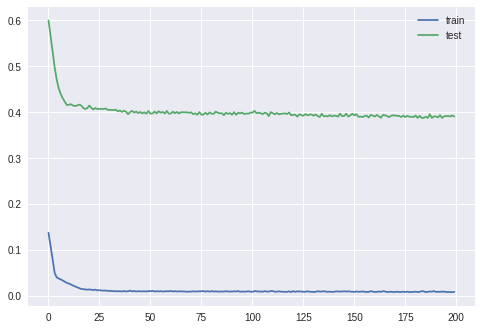

In [0]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
yhat = model.predict(test_X)
new_df = abc(yhat,test_X)

new_df.columns = values_3.columns
scale_up = new_df*(values_3.max()-values_3.min())+values_3.min()

inv_yhat = scale_up.iloc[:,5]
test_y = test_y.reshape((len(test_y), 1))
new_df_1 = abc(test_y,test_X)
new_df_1.columns = values_3.columns
scale_up_1 = new_df_1*(values_3.max()-values_3.min())+values_3.min()
inv_y = scale_up_1.iloc[:,5]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.176


In [0]:
train_y[-1]

0.21601945

In [0]:
yhat_list = [i[0] for i in yhat]
yhat_list

change=[]
for i,j in enumerate(yhat_list):
  if i == 0:
    change.append(yhat_list[i]/train_y[-1])
  if (i==len(yhat_list)-1):
    break
  change.append(yhat_list[i+1]/yhat_list[i])
  
change

vals = 0.451 * np.array([0.9871648, 1.1882874, 1.4612359, 1.3078793])

pred_vals = {}
pred_vals[2015]=0.451
for i in range(2016,2020):
  pred_vals[i]=vals[i-2016]
  
pred_vals

{2015: 0.451,
 2016: 0.4452113248,
 2017: 0.5359176174000001,
 2018: 0.6590173909,
 2019: 0.5898535643}

In [0]:
df['CURRENT_MEDIAN_PRICE']

fig, ax = plt.subplots(figsize = (15,5)) 
line = sns.lineplot(grouped_properties_1990_2018.YEAR_BUILT, grouped_properties_1990_2018.c, ax = ax) 
sns.set_style("whitegrid")
ax.set_ylabel('No. of properties') 
ax.set_ylim(0,7000)
ax.set_xlim(1900,2020)
ax.set_xlabel('Year')
ax.set_title('Number of properties built in Vancouver between year 1900 - 2018')

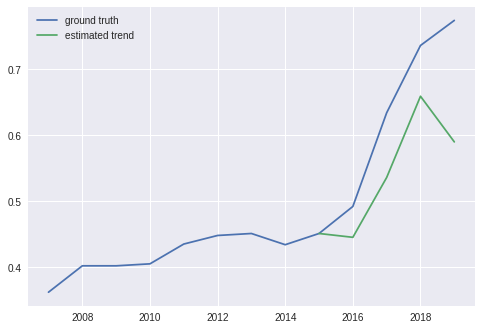

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = df['TAX_ASSESSMENT_YEAR']

plt.plot(x, df['CURRENT_MEDIAN_PRICE'])
plt.plot(pred_vals.keys(), pred_vals.values())
plt.legend(['ground truth', 'estimated trend'], loc='upper left')
plt.savefig('LSTM.png')
plt.show()


In [0]:
output = model.predict(np.array([[[0.08202251, 0.6601942 , 0.08202251, 0.907767  , 0.08202251]]]))

In [0]:
result=output[0][0]*(inv_y.max()-inv_y.min())+inv_y.min()

In [0]:
def plot_forecasts(series, forecasts, n_test):
    pyplot.figure(figsize=(10,5))
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
#     for i in range(len(forecasts)):
#         #off_s = len(series) - n_test + i
#         #off_e = off_s + len(forecasts[i])
#         xaxis = [x for x in range(11, 12)]
    for i in range(len(forecasts)):
      pyplot.plot([11,12], [forecasts[i],forecasts[i]], color='red')
    # show the plot
    pyplot.show()

In [0]:
result

0.6285655332380634

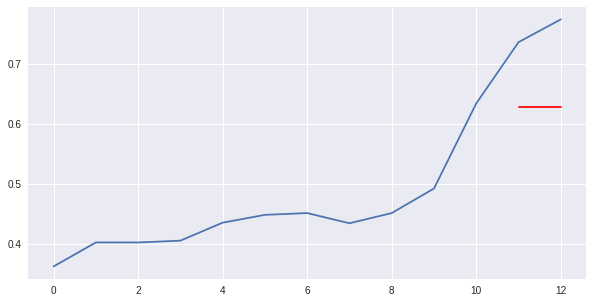

In [0]:
plot_forecasts(df['CURRENT_MEDIAN_PRICE'],[result],1)

In [0]:
print(test_X[3][0][0])

0.08202251


(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 5s - loss: 0.3072 - val_loss: 0.8371
Epoch 2/50
 - 0s - loss: 0.3024 - val_loss: 0.8300
Epoch 3/50
 - 0s - loss: 0.2969 - val_loss: 0.8219
Epoch 4/50
 - 0s - loss: 0.2905 - val_loss: 0.8142
Epoch 5/50
 - 0s - loss: 0.2845 - val_loss: 0.8064
Epoch 6/50
 - 0s - loss: 0.2783 - val_loss: 0.7985
Epoch 7/50
 - 0s - loss: 0.2721 - val_loss: 0.7905
Epoch 8/50
 - 0s - loss: 0.2658 - val_loss: 0.7825
Epoch 9/50
 - 0s - loss: 0.2595 - val_loss: 0.7744
Epoch 10/50
 - 0s - loss: 0.2532 - val_loss: 0.7662
Epoch 11/50
 - 0s - loss: 0.2468 - val_loss: 0.7580
Epoch 12/50
 - 0s - loss: 0.2404 - val_loss: 0.7498
Epoch 13/50
 - 0s - loss: 0.2339 - val_loss: 0.7414
Epoch 14/50
 - 0s - loss: 0.2274 - val_loss: 0.7331
Epoch 15/50
 - 0s - loss: 0.2209 - val_loss: 0.7247
Epoch 16/50
 - 0s - loss: 0.2144 - val_loss: 0.7162
Epoch 17/50
 - 0s - loss: 0.2078 - val_loss: 0.7077
Epoch 18/50
 - 0s - loss: 0.2012 - val_loss: 0.6991
E

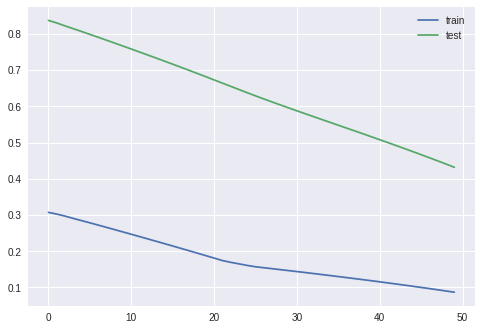

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 5s - loss: 0.1974 - val_loss: 0.7093
Epoch 2/50
 - 0s - loss: 0.1935 - val_loss: 0.7044
Epoch 3/50
 - 0s - loss: 0.1890 - val_loss: 0.6992
Epoch 4/50
 - 0s - loss: 0.1842 - val_loss: 0.6935
Epoch 5/50
 - 0s - loss: 0.1790 - val_loss: 0.6881
Epoch 6/50
 - 0s - loss: 0.1740 - val_loss: 0.6825
Epoch 7/50
 - 0s - loss: 0.1689 - val_loss: 0.6769
Epoch 8/50
 - 0s - loss: 0.1637 - val_loss: 0.6712
Epoch 9/50
 - 0s - loss: 0.1585 - val_loss: 0.6655
Epoch 10/50
 - 0s - loss: 0.1533 - val_loss: 0.6597
Epoch 11/50
 - 0s - loss: 0.1480 - val_loss: 0.6539
Epoch 12/50
 - 0s - loss: 0.1427 - val_loss: 0.6481
Epoch 13/50
 - 0s - loss: 0.1373 - val_loss: 0.6422
Epoch 14/50
 - 0s - loss: 0.1320 - val_loss: 0.6363
Epoch 15/50
 - 0s - loss: 0.1266 - val_loss: 0.6303
Epoch 16/50
 - 0s - loss: 0.1211 - val_loss: 0.6243
Epoch 17/50
 - 0s - loss: 0.1156 - val_loss: 0.6182
Epoch 18/50
 - 0s - loss: 0.1101 - val_loss: 0.6121
E

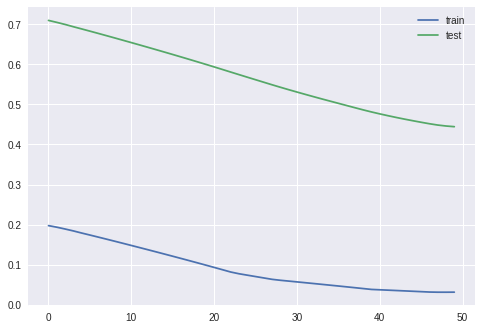

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 5s - loss: 0.2681 - val_loss: 0.8783
Epoch 2/50
 - 0s - loss: 0.2636 - val_loss: 0.8718
Epoch 3/50
 - 0s - loss: 0.2583 - val_loss: 0.8648
Epoch 4/50
 - 0s - loss: 0.2528 - val_loss: 0.8577
Epoch 5/50
 - 0s - loss: 0.2470 - val_loss: 0.8503
Epoch 6/50
 - 0s - loss: 0.2412 - val_loss: 0.8429
Epoch 7/50
 - 0s - loss: 0.2353 - val_loss: 0.8354
Epoch 8/50
 - 0s - loss: 0.2294 - val_loss: 0.8278
Epoch 9/50
 - 0s - loss: 0.2234 - val_loss: 0.8201
Epoch 10/50
 - 0s - loss: 0.2173 - val_loss: 0.8125
Epoch 11/50
 - 0s - loss: 0.2113 - val_loss: 0.8047
Epoch 12/50
 - 0s - loss: 0.2052 - val_loss: 0.7970
Epoch 13/50
 - 0s - loss: 0.1990 - val_loss: 0.7892
Epoch 14/50
 - 0s - loss: 0.1929 - val_loss: 0.7813
Epoch 15/50
 - 0s - loss: 0.1867 - val_loss: 0.7735
Epoch 16/50
 - 0s - loss: 0.1805 - val_loss: 0.7656
Epoch 17/50
 - 0s - loss: 0.1765 - val_loss: 0.7579
Epoch 18/50
 - 0s - loss: 0.1745 - val_loss: 0.7504
E

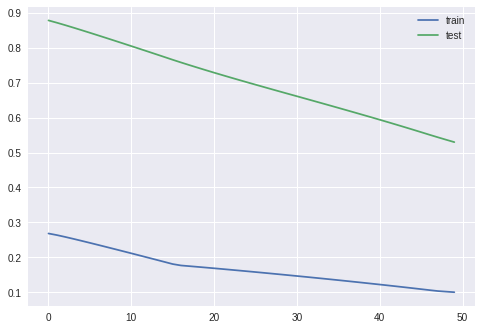

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 6s - loss: 0.2127 - val_loss: 0.7335
Epoch 2/50
 - 0s - loss: 0.2085 - val_loss: 0.7281
Epoch 3/50
 - 0s - loss: 0.2036 - val_loss: 0.7223
Epoch 4/50
 - 0s - loss: 0.1985 - val_loss: 0.7164
Epoch 5/50
 - 0s - loss: 0.1931 - val_loss: 0.7103
Epoch 6/50
 - 0s - loss: 0.1877 - val_loss: 0.7040
Epoch 7/50
 - 0s - loss: 0.1820 - val_loss: 0.6977
Epoch 8/50
 - 0s - loss: 0.1765 - val_loss: 0.6914
Epoch 9/50
 - 0s - loss: 0.1708 - val_loss: 0.6850
Epoch 10/50
 - 0s - loss: 0.1651 - val_loss: 0.6787
Epoch 11/50
 - 0s - loss: 0.1594 - val_loss: 0.6722
Epoch 12/50
 - 0s - loss: 0.1537 - val_loss: 0.6658
Epoch 13/50
 - 0s - loss: 0.1479 - val_loss: 0.6593
Epoch 14/50
 - 0s - loss: 0.1422 - val_loss: 0.6527
Epoch 15/50
 - 0s - loss: 0.1363 - val_loss: 0.6461
Epoch 16/50
 - 0s - loss: 0.1304 - val_loss: 0.6395
Epoch 17/50
 - 0s - loss: 0.1256 - val_loss: 0.6329
Epoch 18/50
 - 0s - loss: 0.1220 - val_loss: 0.6263
E

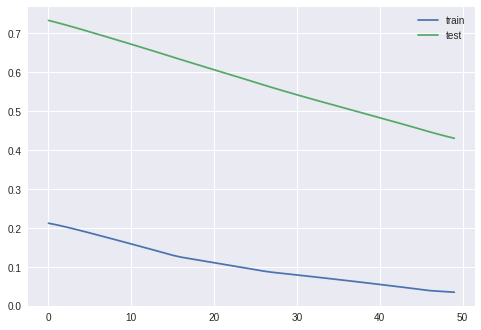

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 6s - loss: 0.1996 - val_loss: 0.8149
Epoch 2/50
 - 0s - loss: 0.1954 - val_loss: 0.8089
Epoch 3/50
 - 0s - loss: 0.1906 - val_loss: 0.8024
Epoch 4/50
 - 0s - loss: 0.1855 - val_loss: 0.7958
Epoch 5/50
 - 0s - loss: 0.1803 - val_loss: 0.7890
Epoch 6/50
 - 0s - loss: 0.1749 - val_loss: 0.7821
Epoch 7/50
 - 0s - loss: 0.1695 - val_loss: 0.7751
Epoch 8/50
 - 0s - loss: 0.1640 - val_loss: 0.7681
Epoch 9/50
 - 0s - loss: 0.1585 - val_loss: 0.7610
Epoch 10/50
 - 0s - loss: 0.1529 - val_loss: 0.7537
Epoch 11/50
 - 0s - loss: 0.1473 - val_loss: 0.7465
Epoch 12/50
 - 0s - loss: 0.1416 - val_loss: 0.7392
Epoch 13/50
 - 0s - loss: 0.1360 - val_loss: 0.7318
Epoch 14/50
 - 0s - loss: 0.1303 - val_loss: 0.7244
Epoch 15/50
 - 0s - loss: 0.1257 - val_loss: 0.7170
Epoch 16/50
 - 0s - loss: 0.1223 - val_loss: 0.7096
Epoch 17/50
 - 0s - loss: 0.1189 - val_loss: 0.7022
Epoch 18/50
 - 0s - loss: 0.1156 - val_loss: 0.6948
E

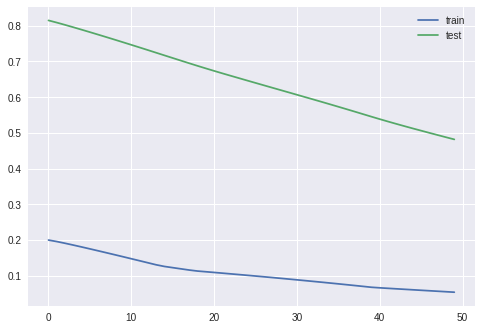

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 6s - loss: 0.1945 - val_loss: 0.8438
Epoch 2/50
 - 0s - loss: 0.1904 - val_loss: 0.8377
Epoch 3/50
 - 0s - loss: 0.1857 - val_loss: 0.8313
Epoch 4/50
 - 0s - loss: 0.1806 - val_loss: 0.8246
Epoch 5/50
 - 0s - loss: 0.1754 - val_loss: 0.8177
Epoch 6/50
 - 0s - loss: 0.1701 - val_loss: 0.8108
Epoch 7/50
 - 0s - loss: 0.1647 - val_loss: 0.8038
Epoch 8/50
 - 0s - loss: 0.1593 - val_loss: 0.7967
Epoch 9/50
 - 0s - loss: 0.1538 - val_loss: 0.7895
Epoch 10/50
 - 0s - loss: 0.1483 - val_loss: 0.7823
Epoch 11/50
 - 0s - loss: 0.1427 - val_loss: 0.7750
Epoch 12/50
 - 0s - loss: 0.1371 - val_loss: 0.7677
Epoch 13/50
 - 0s - loss: 0.1315 - val_loss: 0.7603
Epoch 14/50
 - 0s - loss: 0.1271 - val_loss: 0.7530
Epoch 15/50
 - 0s - loss: 0.1239 - val_loss: 0.7457
Epoch 16/50
 - 0s - loss: 0.1206 - val_loss: 0.7384
Epoch 17/50
 - 0s - loss: 0.1174 - val_loss: 0.7311
Epoch 18/50
 - 0s - loss: 0.1141 - val_loss: 0.7238
E

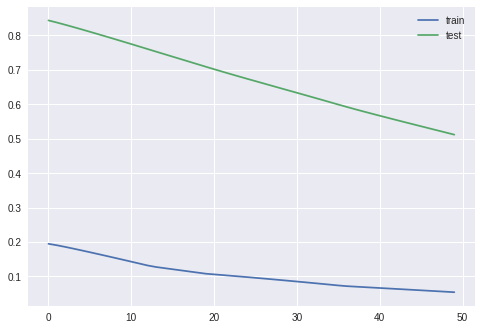

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 6s - loss: 0.1902 - val_loss: 0.8922
Epoch 2/50
 - 0s - loss: 0.1863 - val_loss: 0.8866
Epoch 3/50
 - 0s - loss: 0.1817 - val_loss: 0.8806
Epoch 4/50
 - 0s - loss: 0.1769 - val_loss: 0.8745
Epoch 5/50
 - 0s - loss: 0.1719 - val_loss: 0.8682
Epoch 6/50
 - 0s - loss: 0.1687 - val_loss: 0.8616
Epoch 7/50
 - 0s - loss: 0.1657 - val_loss: 0.8552
Epoch 8/50
 - 0s - loss: 0.1627 - val_loss: 0.8486
Epoch 9/50
 - 0s - loss: 0.1596 - val_loss: 0.8420
Epoch 10/50
 - 0s - loss: 0.1565 - val_loss: 0.8354
Epoch 11/50
 - 0s - loss: 0.1535 - val_loss: 0.8288
Epoch 12/50
 - 0s - loss: 0.1504 - val_loss: 0.8222
Epoch 13/50
 - 0s - loss: 0.1473 - val_loss: 0.8154
Epoch 14/50
 - 0s - loss: 0.1452 - val_loss: 0.8088
Epoch 15/50
 - 0s - loss: 0.1432 - val_loss: 0.8023
Epoch 16/50
 - 0s - loss: 0.1412 - val_loss: 0.7958
Epoch 17/50
 - 0s - loss: 0.1391 - val_loss: 0.7894
Epoch 18/50
 - 0s - loss: 0.1370 - val_loss: 0.7830
E

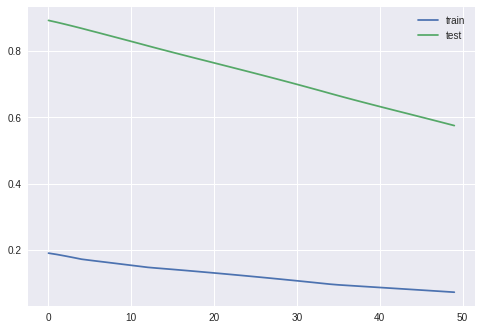

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 6s - loss: 0.2923 - val_loss: 0.8433
Epoch 2/50
 - 0s - loss: 0.2881 - val_loss: 0.8373
Epoch 3/50
 - 0s - loss: 0.2832 - val_loss: 0.8302
Epoch 4/50
 - 0s - loss: 0.2775 - val_loss: 0.8231
Epoch 5/50
 - 0s - loss: 0.2717 - val_loss: 0.8164
Epoch 6/50
 - 0s - loss: 0.2663 - val_loss: 0.8094
Epoch 7/50
 - 0s - loss: 0.2607 - val_loss: 0.8024
Epoch 8/50
 - 0s - loss: 0.2550 - val_loss: 0.7953
Epoch 9/50
 - 0s - loss: 0.2493 - val_loss: 0.7882
Epoch 10/50
 - 0s - loss: 0.2436 - val_loss: 0.7809
Epoch 11/50
 - 0s - loss: 0.2378 - val_loss: 0.7736
Epoch 12/50
 - 0s - loss: 0.2320 - val_loss: 0.7662
Epoch 13/50
 - 0s - loss: 0.2284 - val_loss: 0.7589
Epoch 14/50
 - 0s - loss: 0.2247 - val_loss: 0.7515
Epoch 15/50
 - 0s - loss: 0.2211 - val_loss: 0.7442
Epoch 16/50
 - 0s - loss: 0.2174 - val_loss: 0.7368
Epoch 17/50
 - 0s - loss: 0.2137 - val_loss: 0.7294
Epoch 18/50
 - 0s - loss: 0.2100 - val_loss: 0.7221
E

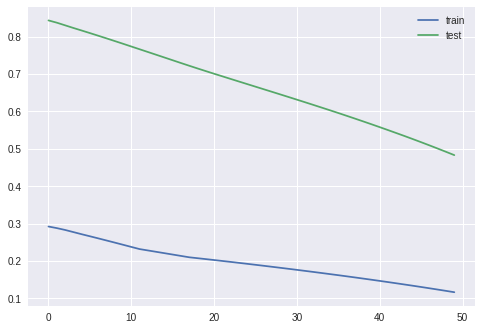

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.2260 - val_loss: 0.8611
Epoch 2/50
 - 0s - loss: 0.2218 - val_loss: 0.8548
Epoch 3/50
 - 0s - loss: 0.2168 - val_loss: 0.8481
Epoch 4/50
 - 0s - loss: 0.2117 - val_loss: 0.8413
Epoch 5/50
 - 0s - loss: 0.2063 - val_loss: 0.8343
Epoch 6/50
 - 0s - loss: 0.2019 - val_loss: 0.8272
Epoch 7/50
 - 0s - loss: 0.1987 - val_loss: 0.8201
Epoch 8/50
 - 0s - loss: 0.1955 - val_loss: 0.8130
Epoch 9/50
 - 0s - loss: 0.1922 - val_loss: 0.8059
Epoch 10/50
 - 0s - loss: 0.1890 - val_loss: 0.7988
Epoch 11/50
 - 0s - loss: 0.1857 - val_loss: 0.7917
Epoch 12/50
 - 0s - loss: 0.1825 - val_loss: 0.7846
Epoch 13/50
 - 0s - loss: 0.1803 - val_loss: 0.7776
Epoch 14/50
 - 0s - loss: 0.1782 - val_loss: 0.7708
Epoch 15/50
 - 0s - loss: 0.1760 - val_loss: 0.7641
Epoch 16/50
 - 0s - loss: 0.1738 - val_loss: 0.7575
Epoch 17/50
 - 0s - loss: 0.1716 - val_loss: 0.7509
Epoch 18/50
 - 0s - loss: 0.1693 - val_loss: 0.7444
E

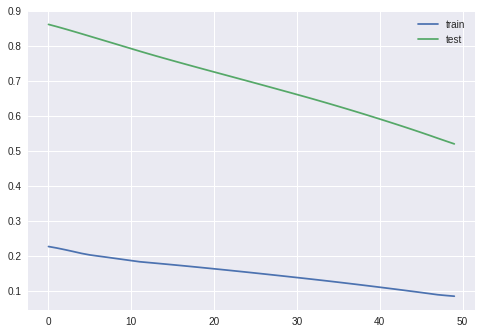

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.1911 - val_loss: 0.7698
Epoch 2/50
 - 0s - loss: 0.1869 - val_loss: 0.7634
Epoch 3/50
 - 0s - loss: 0.1812 - val_loss: 0.7571
Epoch 4/50
 - 0s - loss: 0.1756 - val_loss: 0.7507
Epoch 5/50
 - 0s - loss: 0.1700 - val_loss: 0.7443
Epoch 6/50
 - 0s - loss: 0.1644 - val_loss: 0.7382
Epoch 7/50
 - 0s - loss: 0.1590 - val_loss: 0.7319
Epoch 8/50
 - 0s - loss: 0.1534 - val_loss: 0.7256
Epoch 9/50
 - 0s - loss: 0.1479 - val_loss: 0.7193
Epoch 10/50
 - 0s - loss: 0.1423 - val_loss: 0.7130
Epoch 11/50
 - 0s - loss: 0.1368 - val_loss: 0.7067
Epoch 12/50
 - 0s - loss: 0.1312 - val_loss: 0.7003
Epoch 13/50
 - 0s - loss: 0.1256 - val_loss: 0.6940
Epoch 14/50
 - 0s - loss: 0.1200 - val_loss: 0.6875
Epoch 15/50
 - 0s - loss: 0.1143 - val_loss: 0.6812
Epoch 16/50
 - 0s - loss: 0.1105 - val_loss: 0.6751
Epoch 17/50
 - 0s - loss: 0.1088 - val_loss: 0.6692
Epoch 18/50
 - 0s - loss: 0.1071 - val_loss: 0.6635
E

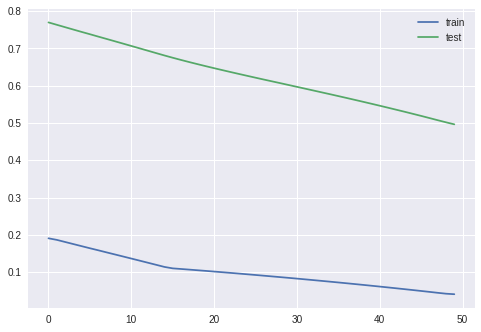

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.2706 - val_loss: 0.7920
Epoch 2/50
 - 0s - loss: 0.2663 - val_loss: 0.7858
Epoch 3/50
 - 0s - loss: 0.2614 - val_loss: 0.7792
Epoch 4/50
 - 0s - loss: 0.2561 - val_loss: 0.7725
Epoch 5/50
 - 0s - loss: 0.2508 - val_loss: 0.7656
Epoch 6/50
 - 0s - loss: 0.2453 - val_loss: 0.7586
Epoch 7/50
 - 0s - loss: 0.2397 - val_loss: 0.7516
Epoch 8/50
 - 0s - loss: 0.2341 - val_loss: 0.7445
Epoch 9/50
 - 0s - loss: 0.2284 - val_loss: 0.7374
Epoch 10/50
 - 0s - loss: 0.2227 - val_loss: 0.7303
Epoch 11/50
 - 0s - loss: 0.2170 - val_loss: 0.7231
Epoch 12/50
 - 0s - loss: 0.2112 - val_loss: 0.7158
Epoch 13/50
 - 0s - loss: 0.2054 - val_loss: 0.7086
Epoch 14/50
 - 0s - loss: 0.1997 - val_loss: 0.7012
Epoch 15/50
 - 0s - loss: 0.1962 - val_loss: 0.6939
Epoch 16/50
 - 0s - loss: 0.1927 - val_loss: 0.6866
Epoch 17/50
 - 0s - loss: 0.1891 - val_loss: 0.6793
Epoch 18/50
 - 0s - loss: 0.1856 - val_loss: 0.6719
E

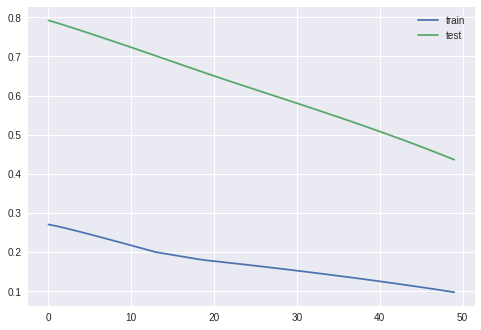

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.1830 - val_loss: 0.7025
Epoch 2/50
 - 0s - loss: 0.1789 - val_loss: 0.6973
Epoch 3/50
 - 0s - loss: 0.1741 - val_loss: 0.6918
Epoch 4/50
 - 0s - loss: 0.1690 - val_loss: 0.6862
Epoch 5/50
 - 0s - loss: 0.1637 - val_loss: 0.6803
Epoch 6/50
 - 0s - loss: 0.1583 - val_loss: 0.6744
Epoch 7/50
 - 0s - loss: 0.1528 - val_loss: 0.6685
Epoch 8/50
 - 0s - loss: 0.1488 - val_loss: 0.6625
Epoch 9/50
 - 0s - loss: 0.1455 - val_loss: 0.6566
Epoch 10/50
 - 0s - loss: 0.1422 - val_loss: 0.6506
Epoch 11/50
 - 0s - loss: 0.1388 - val_loss: 0.6447
Epoch 12/50
 - 0s - loss: 0.1355 - val_loss: 0.6388
Epoch 13/50
 - 0s - loss: 0.1321 - val_loss: 0.6329
Epoch 14/50
 - 0s - loss: 0.1287 - val_loss: 0.6270
Epoch 15/50
 - 0s - loss: 0.1253 - val_loss: 0.6210
Epoch 16/50
 - 0s - loss: 0.1219 - val_loss: 0.6151
Epoch 17/50
 - 0s - loss: 0.1185 - val_loss: 0.6091
Epoch 18/50
 - 0s - loss: 0.1151 - val_loss: 0.6031
E

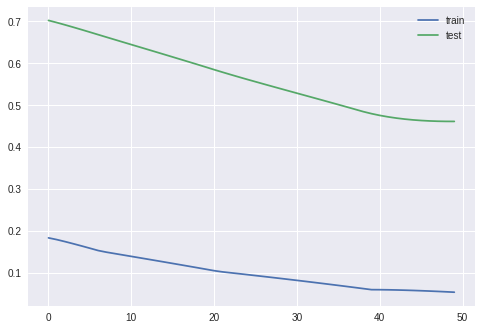

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.2937 - val_loss: 0.8557
Epoch 2/50
 - 0s - loss: 0.2897 - val_loss: 0.8483
Epoch 3/50
 - 0s - loss: 0.2843 - val_loss: 0.8417
Epoch 4/50
 - 0s - loss: 0.2794 - val_loss: 0.8348
Epoch 5/50
 - 0s - loss: 0.2743 - val_loss: 0.8278
Epoch 6/50
 - 0s - loss: 0.2692 - val_loss: 0.8204
Epoch 7/50
 - 0s - loss: 0.2637 - val_loss: 0.8133
Epoch 8/50
 - 0s - loss: 0.2584 - val_loss: 0.8059
Epoch 9/50
 - 0s - loss: 0.2530 - val_loss: 0.7986
Epoch 10/50
 - 0s - loss: 0.2476 - val_loss: 0.7912
Epoch 11/50
 - 0s - loss: 0.2421 - val_loss: 0.7838
Epoch 12/50
 - 0s - loss: 0.2366 - val_loss: 0.7763
Epoch 13/50
 - 0s - loss: 0.2311 - val_loss: 0.7687
Epoch 14/50
 - 0s - loss: 0.2255 - val_loss: 0.7611
Epoch 15/50
 - 0s - loss: 0.2217 - val_loss: 0.7535
Epoch 16/50
 - 0s - loss: 0.2182 - val_loss: 0.7459
Epoch 17/50
 - 0s - loss: 0.2146 - val_loss: 0.7384
Epoch 18/50
 - 0s - loss: 0.2110 - val_loss: 0.7308
E

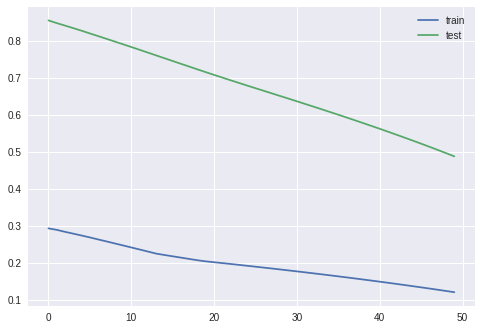

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 7s - loss: 0.1841 - val_loss: 0.8880
Epoch 2/50
 - 0s - loss: 0.1812 - val_loss: 0.8821
Epoch 3/50
 - 0s - loss: 0.1785 - val_loss: 0.8758
Epoch 4/50
 - 0s - loss: 0.1756 - val_loss: 0.8694
Epoch 5/50
 - 0s - loss: 0.1726 - val_loss: 0.8628
Epoch 6/50
 - 0s - loss: 0.1704 - val_loss: 0.8564
Epoch 7/50
 - 0s - loss: 0.1684 - val_loss: 0.8500
Epoch 8/50
 - 0s - loss: 0.1663 - val_loss: 0.8437
Epoch 9/50
 - 0s - loss: 0.1642 - val_loss: 0.8375
Epoch 10/50
 - 0s - loss: 0.1620 - val_loss: 0.8313
Epoch 11/50
 - 0s - loss: 0.1598 - val_loss: 0.8251
Epoch 12/50
 - 0s - loss: 0.1576 - val_loss: 0.8190
Epoch 13/50
 - 0s - loss: 0.1553 - val_loss: 0.8129
Epoch 14/50
 - 0s - loss: 0.1530 - val_loss: 0.8067
Epoch 15/50
 - 0s - loss: 0.1507 - val_loss: 0.8006
Epoch 16/50
 - 0s - loss: 0.1484 - val_loss: 0.7944
Epoch 17/50
 - 0s - loss: 0.1460 - val_loss: 0.7882
Epoch 18/50
 - 0s - loss: 0.1436 - val_loss: 0.7820
E

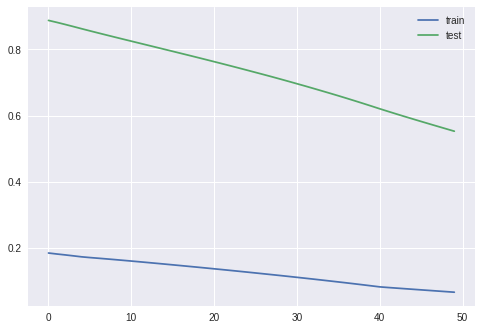

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 8s - loss: 0.1934 - val_loss: 0.8749
Epoch 2/50
 - 0s - loss: 0.1909 - val_loss: 0.8683
Epoch 3/50
 - 0s - loss: 0.1880 - val_loss: 0.8613
Epoch 4/50
 - 0s - loss: 0.1848 - val_loss: 0.8541
Epoch 5/50
 - 0s - loss: 0.1816 - val_loss: 0.8463
Epoch 6/50
 - 0s - loss: 0.1782 - val_loss: 0.8388
Epoch 7/50
 - 0s - loss: 0.1748 - val_loss: 0.8312
Epoch 8/50
 - 0s - loss: 0.1714 - val_loss: 0.8235
Epoch 9/50
 - 0s - loss: 0.1685 - val_loss: 0.8161
Epoch 10/50
 - 0s - loss: 0.1662 - val_loss: 0.8089
Epoch 11/50
 - 0s - loss: 0.1639 - val_loss: 0.8018
Epoch 12/50
 - 0s - loss: 0.1614 - val_loss: 0.7949
Epoch 13/50
 - 0s - loss: 0.1590 - val_loss: 0.7879
Epoch 14/50
 - 0s - loss: 0.1565 - val_loss: 0.7811
Epoch 15/50
 - 0s - loss: 0.1540 - val_loss: 0.7742
Epoch 16/50
 - 0s - loss: 0.1515 - val_loss: 0.7675
Epoch 17/50
 - 0s - loss: 0.1490 - val_loss: 0.7606
Epoch 18/50
 - 0s - loss: 0.1464 - val_loss: 0.7538
E

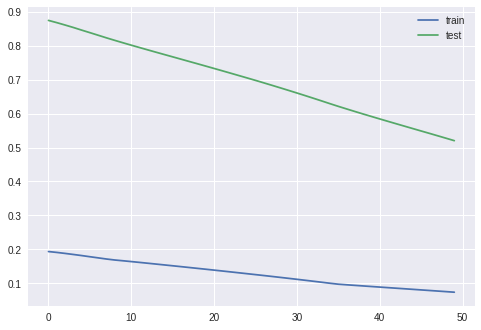

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 8s - loss: 0.3334 - val_loss: 0.8682
Epoch 2/50
 - 0s - loss: 0.3289 - val_loss: 0.8615
Epoch 3/50
 - 0s - loss: 0.3238 - val_loss: 0.8544
Epoch 4/50
 - 0s - loss: 0.3184 - val_loss: 0.8471
Epoch 5/50
 - 0s - loss: 0.3128 - val_loss: 0.8396
Epoch 6/50
 - 0s - loss: 0.3071 - val_loss: 0.8318
Epoch 7/50
 - 0s - loss: 0.3011 - val_loss: 0.8242
Epoch 8/50
 - 0s - loss: 0.2953 - val_loss: 0.8164
Epoch 9/50
 - 0s - loss: 0.2894 - val_loss: 0.8086
Epoch 10/50
 - 0s - loss: 0.2834 - val_loss: 0.8007
Epoch 11/50
 - 0s - loss: 0.2774 - val_loss: 0.7927
Epoch 12/50
 - 0s - loss: 0.2714 - val_loss: 0.7847
Epoch 13/50
 - 0s - loss: 0.2653 - val_loss: 0.7766
Epoch 14/50
 - 0s - loss: 0.2593 - val_loss: 0.7685
Epoch 15/50
 - 0s - loss: 0.2542 - val_loss: 0.7604
Epoch 16/50
 - 0s - loss: 0.2503 - val_loss: 0.7524
Epoch 17/50
 - 0s - loss: 0.2465 - val_loss: 0.7444
Epoch 18/50
 - 0s - loss: 0.2426 - val_loss: 0.7364
E

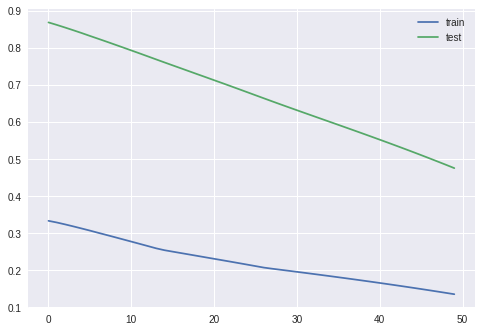

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 8s - loss: 0.2728 - val_loss: 0.8805
Epoch 2/50
 - 0s - loss: 0.2683 - val_loss: 0.8736
Epoch 3/50
 - 0s - loss: 0.2632 - val_loss: 0.8662
Epoch 4/50
 - 0s - loss: 0.2577 - val_loss: 0.8587
Epoch 5/50
 - 0s - loss: 0.2521 - val_loss: 0.8510
Epoch 6/50
 - 0s - loss: 0.2463 - val_loss: 0.8431
Epoch 7/50
 - 0s - loss: 0.2405 - val_loss: 0.8352
Epoch 8/50
 - 0s - loss: 0.2346 - val_loss: 0.8271
Epoch 9/50
 - 0s - loss: 0.2286 - val_loss: 0.8190
Epoch 10/50
 - 0s - loss: 0.2226 - val_loss: 0.8109
Epoch 11/50
 - 0s - loss: 0.2166 - val_loss: 0.8026
Epoch 12/50
 - 0s - loss: 0.2105 - val_loss: 0.7943
Epoch 13/50
 - 0s - loss: 0.2044 - val_loss: 0.7860
Epoch 14/50
 - 0s - loss: 0.1982 - val_loss: 0.7776
Epoch 15/50
 - 0s - loss: 0.1930 - val_loss: 0.7692
Epoch 16/50
 - 0s - loss: 0.1892 - val_loss: 0.7610
Epoch 17/50
 - 0s - loss: 0.1854 - val_loss: 0.7527
Epoch 18/50
 - 0s - loss: 0.1817 - val_loss: 0.7445
E

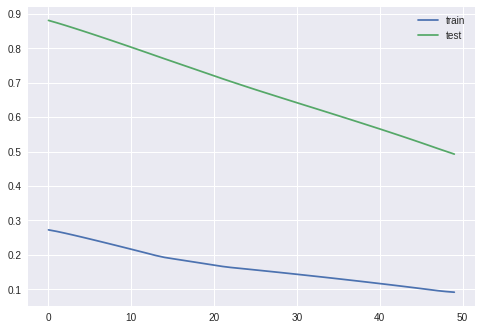

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 8s - loss: 0.1876 - val_loss: 0.8942
Epoch 2/50
 - 0s - loss: 0.1834 - val_loss: 0.8878
Epoch 3/50
 - 0s - loss: 0.1785 - val_loss: 0.8811
Epoch 4/50
 - 0s - loss: 0.1748 - val_loss: 0.8738
Epoch 5/50
 - 0s - loss: 0.1715 - val_loss: 0.8666
Epoch 6/50
 - 0s - loss: 0.1682 - val_loss: 0.8597
Epoch 7/50
 - 0s - loss: 0.1651 - val_loss: 0.8529
Epoch 8/50
 - 0s - loss: 0.1632 - val_loss: 0.8463
Epoch 9/50
 - 0s - loss: 0.1612 - val_loss: 0.8397
Epoch 10/50
 - 0s - loss: 0.1591 - val_loss: 0.8332
Epoch 11/50
 - 0s - loss: 0.1569 - val_loss: 0.8268
Epoch 12/50
 - 0s - loss: 0.1548 - val_loss: 0.8204
Epoch 13/50
 - 0s - loss: 0.1526 - val_loss: 0.8141
Epoch 14/50
 - 0s - loss: 0.1503 - val_loss: 0.8078
Epoch 15/50
 - 0s - loss: 0.1480 - val_loss: 0.8015
Epoch 16/50
 - 0s - loss: 0.1457 - val_loss: 0.7952
Epoch 17/50
 - 0s - loss: 0.1434 - val_loss: 0.7889
Epoch 18/50
 - 0s - loss: 0.1410 - val_loss: 0.7826
E

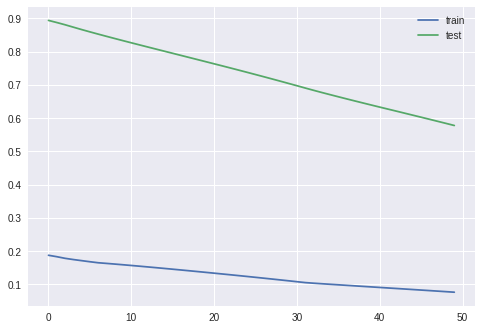

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 9s - loss: 0.1904 - val_loss: 0.8376
Epoch 2/50
 - 0s - loss: 0.1871 - val_loss: 0.8324
Epoch 3/50
 - 0s - loss: 0.1832 - val_loss: 0.8269
Epoch 4/50
 - 0s - loss: 0.1790 - val_loss: 0.8213
Epoch 5/50
 - 0s - loss: 0.1748 - val_loss: 0.8155
Epoch 6/50
 - 0s - loss: 0.1704 - val_loss: 0.8097
Epoch 7/50
 - 0s - loss: 0.1659 - val_loss: 0.8038
Epoch 8/50
 - 0s - loss: 0.1614 - val_loss: 0.7979
Epoch 9/50
 - 0s - loss: 0.1569 - val_loss: 0.7919
Epoch 10/50
 - 0s - loss: 0.1531 - val_loss: 0.7858
Epoch 11/50
 - 0s - loss: 0.1504 - val_loss: 0.7798
Epoch 12/50
 - 0s - loss: 0.1476 - val_loss: 0.7738
Epoch 13/50
 - 0s - loss: 0.1449 - val_loss: 0.7678
Epoch 14/50
 - 0s - loss: 0.1430 - val_loss: 0.7618
Epoch 15/50
 - 0s - loss: 0.1414 - val_loss: 0.7560
Epoch 16/50
 - 0s - loss: 0.1397 - val_loss: 0.7503
Epoch 17/50
 - 0s - loss: 0.1381 - val_loss: 0.7447
Epoch 18/50
 - 0s - loss: 0.1364 - val_loss: 0.7391
E

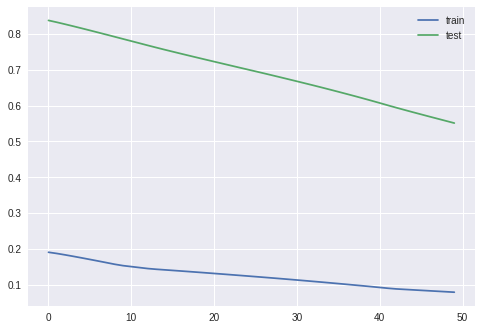

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 9s - loss: 0.1728 - val_loss: 0.6978
Epoch 2/50
 - 0s - loss: 0.1688 - val_loss: 0.6925
Epoch 3/50
 - 0s - loss: 0.1642 - val_loss: 0.6869
Epoch 4/50
 - 0s - loss: 0.1594 - val_loss: 0.6808
Epoch 5/50
 - 0s - loss: 0.1540 - val_loss: 0.6750
Epoch 6/50
 - 0s - loss: 0.1489 - val_loss: 0.6690
Epoch 7/50
 - 0s - loss: 0.1437 - val_loss: 0.6630
Epoch 8/50
 - 0s - loss: 0.1384 - val_loss: 0.6569
Epoch 9/50
 - 0s - loss: 0.1331 - val_loss: 0.6508
Epoch 10/50
 - 0s - loss: 0.1278 - val_loss: 0.6446
Epoch 11/50
 - 0s - loss: 0.1224 - val_loss: 0.6384
Epoch 12/50
 - 0s - loss: 0.1170 - val_loss: 0.6322
Epoch 13/50
 - 0s - loss: 0.1116 - val_loss: 0.6260
Epoch 14/50
 - 0s - loss: 0.1061 - val_loss: 0.6197
Epoch 15/50
 - 0s - loss: 0.1007 - val_loss: 0.6133
Epoch 16/50
 - 0s - loss: 0.0952 - val_loss: 0.6069
Epoch 17/50
 - 0s - loss: 0.0896 - val_loss: 0.6005
Epoch 18/50
 - 0s - loss: 0.0840 - val_loss: 0.5940
E

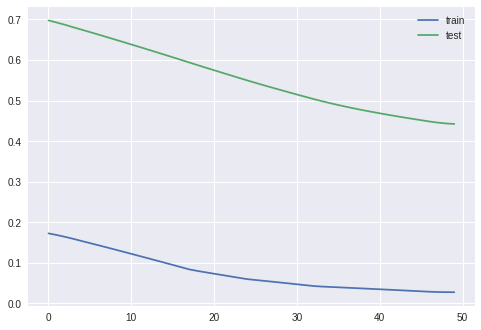

(7, 1, 5) (7,) (4, 1, 5) (4,)
Train on 7 samples, validate on 4 samples
Epoch 1/50
 - 9s - loss: 0.2625 - val_loss: 0.8469
Epoch 2/50
 - 0s - loss: 0.2583 - val_loss: 0.8410
Epoch 3/50
 - 0s - loss: 0.2535 - val_loss: 0.8348
Epoch 4/50
 - 0s - loss: 0.2484 - val_loss: 0.8284
Epoch 5/50
 - 0s - loss: 0.2431 - val_loss: 0.8218
Epoch 6/50
 - 0s - loss: 0.2377 - val_loss: 0.8151
Epoch 7/50
 - 0s - loss: 0.2322 - val_loss: 0.8084
Epoch 8/50
 - 0s - loss: 0.2267 - val_loss: 0.8016
Epoch 9/50
 - 0s - loss: 0.2211 - val_loss: 0.7947
Epoch 10/50
 - 0s - loss: 0.2154 - val_loss: 0.7877
Epoch 11/50
 - 0s - loss: 0.2097 - val_loss: 0.7807
Epoch 12/50
 - 0s - loss: 0.2040 - val_loss: 0.7736
Epoch 13/50
 - 0s - loss: 0.1984 - val_loss: 0.7665
Epoch 14/50
 - 0s - loss: 0.1949 - val_loss: 0.7593
Epoch 15/50
 - 0s - loss: 0.1915 - val_loss: 0.7522
Epoch 16/50
 - 0s - loss: 0.1881 - val_loss: 0.7450
Epoch 17/50
 - 0s - loss: 0.1846 - val_loss: 0.7378
Epoch 18/50
 - 0s - loss: 0.1812 - val_loss: 0.7306
E

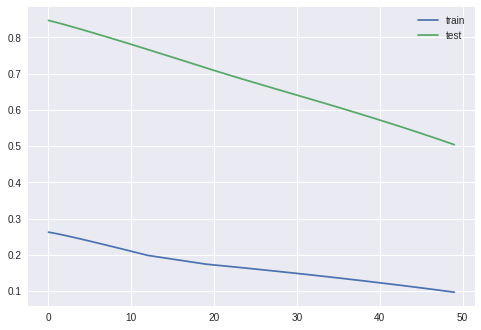

In [0]:
rmse = {}
for i in postals:
  
  temp = df[df['NEIGHBOURHOOD_NAME'] == i]
  temp_1 = temp[['INTEREST_RATE','CURRENT_MEDIAN_PRICE']]
  
  values = temp_1.astype('float32')
  scaled_down = (values-values.min())/(values.max()-values.min())
  data = series_to_supervised(scaled_down,2,1)
  values_3 = pd.concat([values_2,values,values],axis=1)
  values = data.values
  n_train_hours = 7
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  yhat = model.predict(test_X)
  new_df = abc(yhat,test_X)

  new_df.columns = values_3.columns
  scale_up = new_df*(values_3.max()-values_3.min())+values_3.min()

  inv_yhat = scale_up.iloc[:,5]
  test_y = test_y.reshape((len(test_y), 1))
  new_df_1 = abc(test_y,test_X)
  new_df_1.columns = values_3.columns
  scale_up_1 = new_df_1*(values_3.max()-values_3.min())+values_3.min()
  inv_y = scale_up_1.iloc[:,5]

  rmse[i]= sqrt(mean_squared_error(inv_y, inv_yhat))
  #print('Test RMSE: %.3f' % rmse)



In [0]:
rmse


{'Arbutus-Ridge': 1.019390434245272,
 'Downtown': 0.210448816610571,
 'Dunbar-Southlands': 1.3003131079807762,
 'Fairview': 0.20646074099866465,
 'Grandview-Woodland': 0.38627580612299794,
 'Hastings-Sunrise': 0.4612752208308393,
 'Kensington-Cedar Cottage': 0.5050230409696782,
 'Kerrisdale': 1.4157079274071376,
 'Killarney': 0.5066348562247277,
 'Kitsilano': 0.30834425745704763,
 'Marpole': 0.5266578223917437,
 'Mount Pleasant': 0.20497280688767228,
 'Oakridge': 0.8175333118116899,
 'Renfrew-Collingwood': 0.45475525905130576,
 'Riley Park': 0.5552807838571862,
 'Shaughnessy': 1.8532728697012197,
 'South Cambie': 0.877114352804338,
 'Sunset': 0.6185701540354915,
 'Victoria-Fraserview': 0.5433117611331081,
 'West End': 0.20066647898642234,
 'West Point Grey': 1.228333154958494}